In [56]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from ELD.utils import circle_size, colors, toImg, preprocess
from ELD.model import loadFan#, predict_landmarks
from torchgeometry.contrib import spatial_soft_argmax2d
from glob import glob
import tifffile as tiffv
from skimage.transform import rescale
from PIL import Image, ImageEnhance
import cv2
import tifffile

from glob import glob 
import cv2
from ELD.utils import circle_size, colors, toImg, preprocess
from ELD.model import loadFan#, predict_landmarks
from torchgeometry.contrib import spatial_soft_argmax2d
from glob import glob
import torch 

from ELD.warp import Homo, Rigid, TPS

from ELD.utils import (toImg, preprocess, predict_landmarks, create_target_landmarks, 
                       create_target_images, download_images_urls, downscale_images, plot_images, 
                       mask_background, padImg, crop_non_tissue, downsize_and_save, 
                       rescale_landmarks, pad_image_and_adjust_landmarks, corr,plot_warped_images)

In [57]:



def load_imgs(path):
    #get files with glob
    files = glob(f"{path}*")
    #sort files by number
    files = sorted(files, key=lambda x: int(x.split('/')[-1].split('.')[0]))
    #load images
    if files[0].endswith('.tif'):
        imgs = [tiff.imread(f) for f in files]
    else:
        imgs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in files]
    return imgs

In [58]:
PATH = "/data/ekvall/xenium_heart/mip/"

In [60]:
files = glob(f"{PATH}*")

In [61]:
files = sorted(files)

Load images, and flip the last one. Resize them to 120x120 and pad it to 130x130 to avoid weird border effects

In [80]:
images = []
orig_imgs = []
for i, file in enumerate(files):
    print(file)
    # Load the OME-TIFF image
    with tifffile.TiffFile(file) as tif:
        image_data = tif.asarray()
        


    resized_image = cv2.resize(image_data, (image_data.shape[0] // 100, image_data.shape[1] // 100))
    image = np.uint8((resized_image - resized_image.min()) / (resized_image.max() - resized_image.min()) * 255)
    equalized_image = cv2.equalizeHist(image)
    equalized_image = cv2.resize(equalized_image, (120, 120), interpolation=cv2.INTER_AREA)
    
    if i == 7:
        orig_imgs.append(np.rot90(equalized_image, 2).copy()[:,:,None])
    else:
        orig_imgs.append(equalized_image.copy()[:,:,None])
        
    equalized_image = np.pad(equalized_image, 5, mode='constant', constant_values=0)
    
    if i == 7:
        equalized_image = np.rot90(equalized_image, 2)
    images.append(equalized_image)

/data/ekvall/xenium_heart/mip/morphology_mip11.ome.tif
/data/ekvall/xenium_heart/mip/morphology_mip21.ome.tif
/data/ekvall/xenium_heart/mip/morphology_mip31.ome.tif
/data/ekvall/xenium_heart/mip/morphology_mip41.ome.tif
/data/ekvall/xenium_heart/mip/morphology_mip51.ome.tif
/data/ekvall/xenium_heart/mip/morphology_mip61.ome.tif
/data/ekvall/xenium_heart/mip/morphology_mip71.ome.tif
/data/ekvall/xenium_heart/mip/morphology_mip81.ome.tif


In [82]:
from ELD.utils import mask_background

Only keep the most intense neighbourhoods to remove noisy regions. Setting tresholds to 130

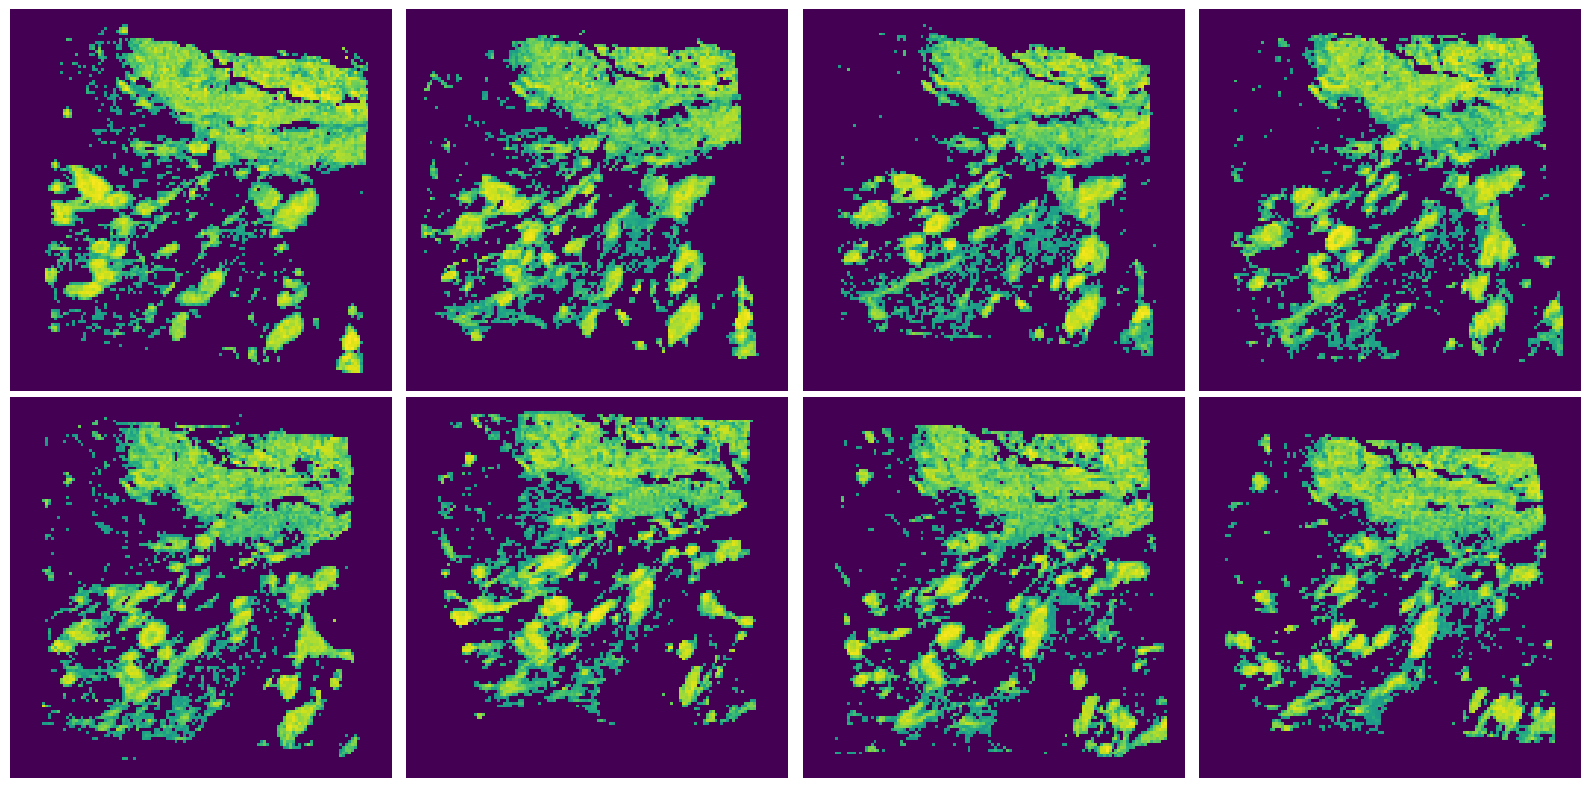

In [118]:
# Set up the figure and axes for plotting
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Loop through the images and plot each one on a subplot
for idx, image in enumerate(images):
    #image = image.copy()
    image[image < 130] = 0
    axes[idx].imshow(image, interpolation='nearest')  # Assuming the images are in a format that imshow can handle
    axes[idx].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()


Save the files and run 'eld-train --elastic_sigma 3.5 --cuda 5 --port 9101 --data_path /data/ekvall/marcoAnalysis/3d_dapi_masked/ --npts 20 --o scratch --ws 1_000 --angle 0.1 --model 3d' in terminal

In [120]:
#save images with name 1, 2, 3, 4, 5, 6, 7, 8 png

for i, image in enumerate(images):
    cv2.imwrite(f"/data/ekvall/marcoAnalysis/3d_dapi_masked/{i}.png", image)

Load the data and model to predict landmarks

In [115]:


PATH = "/data/ekvall/marcoAnalysis/3d_dapi_masked/"

In [116]:
loaded_dapi_imgs = load_imgs(PATH)
image = torch.stack([preprocess(img) for img in loaded_dapi_imgs])


In [16]:
fan = loadFan(npoints=20,n_channels=3,path_to_model="../Exp_56/model_77.fan.pth")

In [117]:
def predict_landmarks(fan, image):
    with torch.no_grad():
        #img = sample['Im']
        
        fan.eval()

        with torch.no_grad():
            pts = 4 * spatial_soft_argmax2d(fan(image.cuda()), False)
    return pts

In [118]:
pts = predict_landmarks(fan, image)
#combine landmarks and image
np_img = toImg(image.cuda()[:,:3], pts, 128)


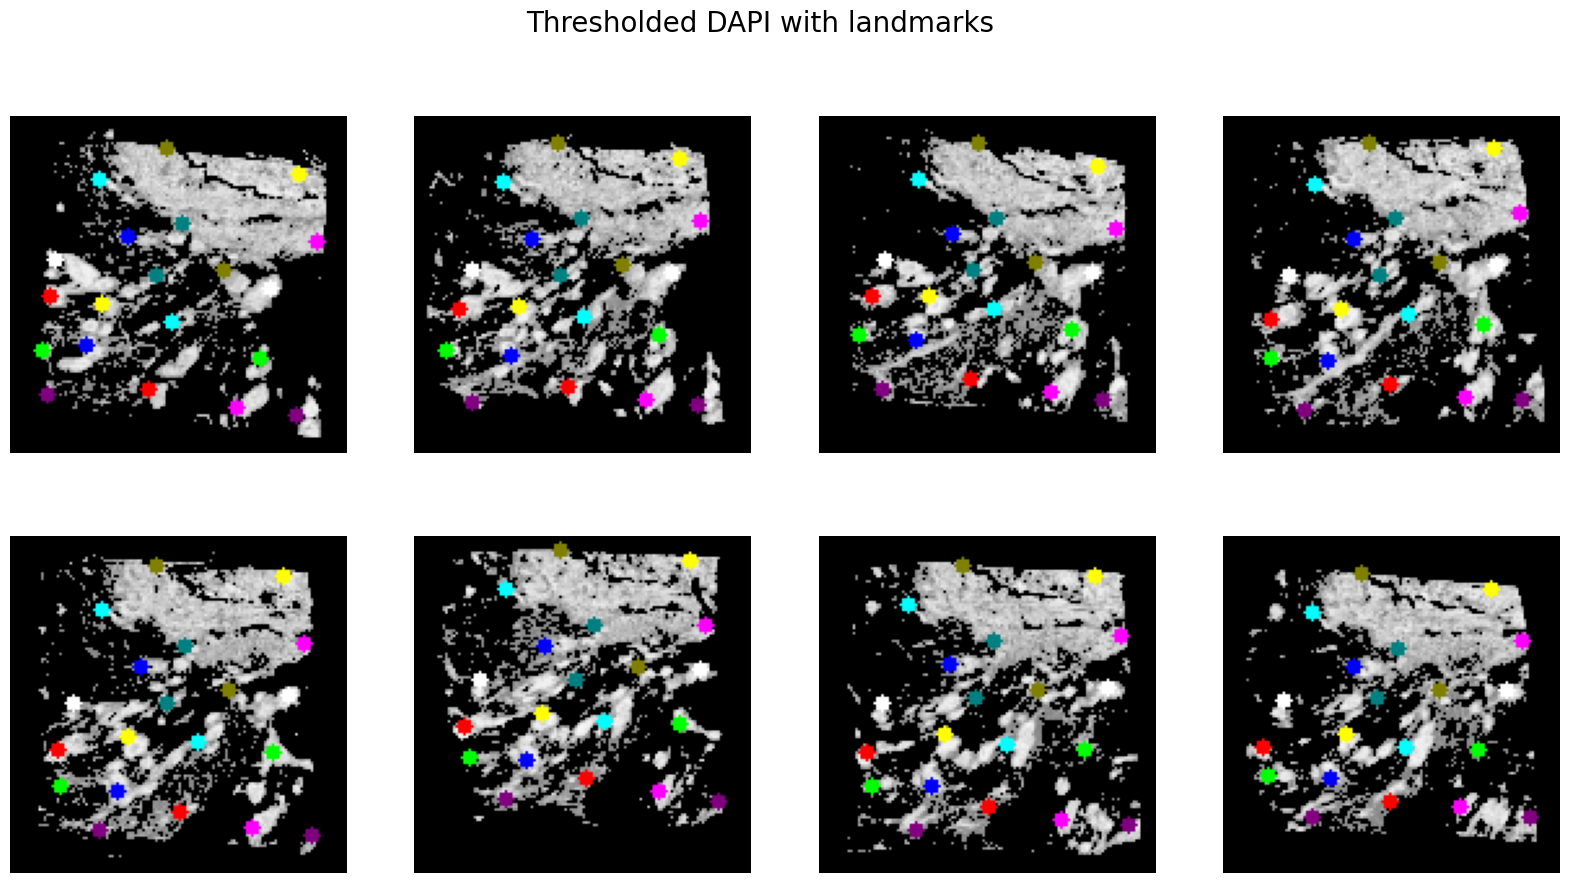

In [121]:
#pick 8 images uniformly for 0..260
idx = np.linspace(0,8).astype(int)
#plot images

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(np_img[i])
    ax.axis('off')
    
fig.suptitle('Thresholded DAPI with landmarks', fontsize=20)
plt.show()


In [122]:
tps_transform = TPS()

In [123]:
dst_pts = create_target_landmarks(pts, 0)

In [128]:
mapped_imgs = tps_transform.warp_img(image.cuda(), pts, dst_pts, reg=0, norm=True, size=130)
mapped_pts = tps_transform.warp_pts(pts, dst_pts, pts, reg=0)

In [129]:
np_img_mapped = toImg(mapped_imgs.cuda()[:,:3], mapped_pts, 128)

Text(0.5, 0.98, 'Mapped DAPI images to first image')

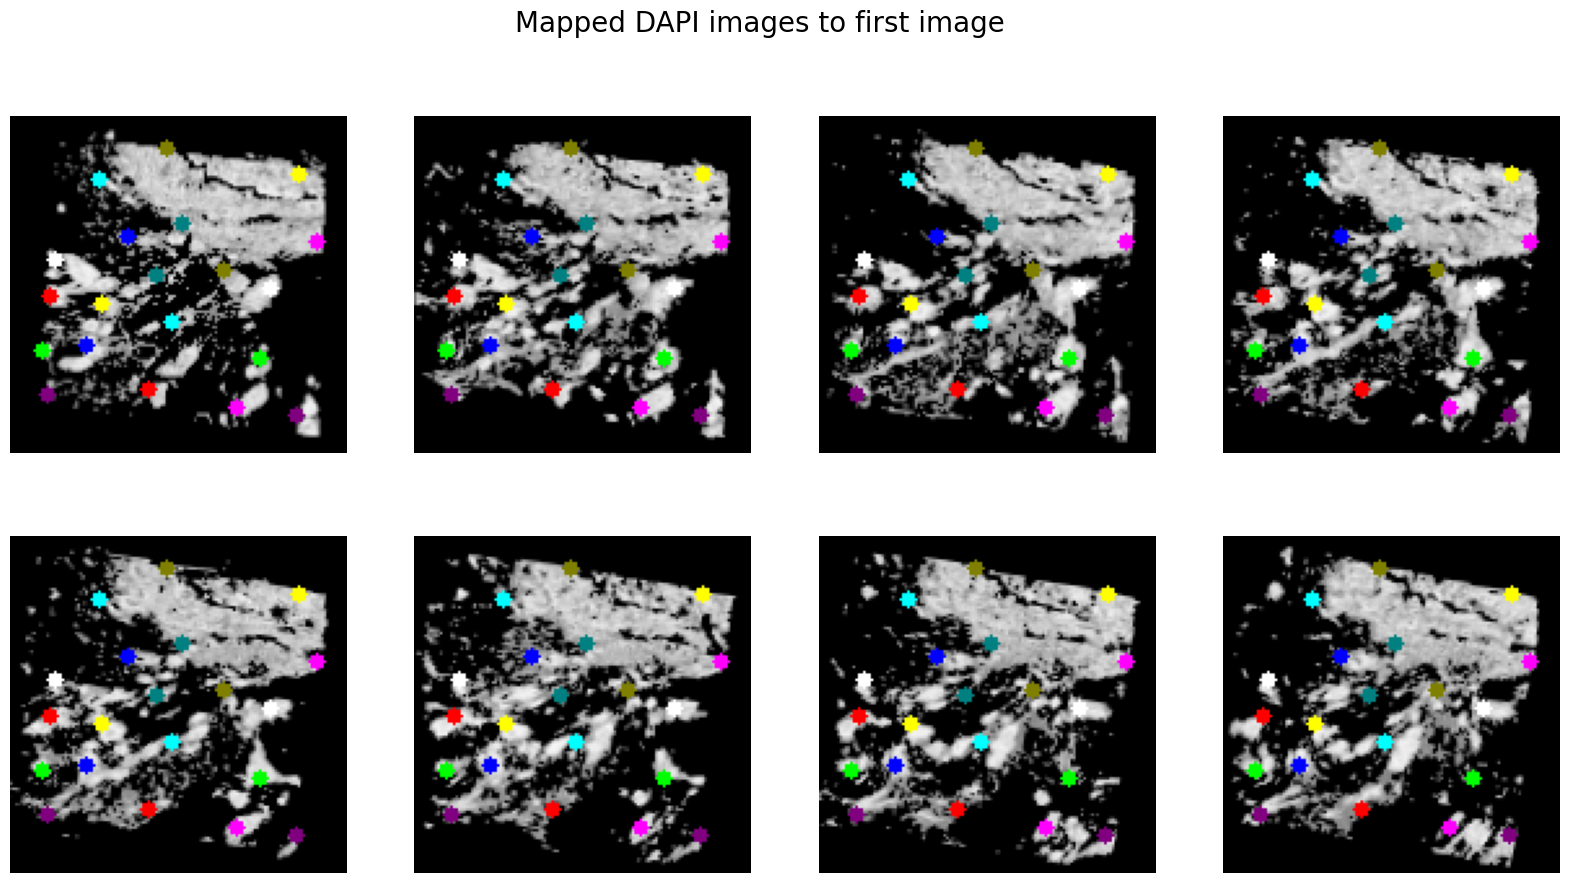

In [130]:
idx = np.linspace(0,8).astype(int)
#plot images

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(np_img_mapped[i])
    ax.axis('off')
    
fig.suptitle('Mapped DAPI images to first image', fontsize=20)

In [131]:
orig_imgs_t  = torch.stack([preprocess(img) for img in orig_imgs])

In [132]:
affine_mapped_imgs = tps_transform.warp_img(orig_imgs_t.cuda(), pts - 5, dst_pts - 5, reg=1e20, norm=True, size=120)
affine_mapped_pts = tps_transform.warp_pts(pts - 5, dst_pts - 5, pts - 5, reg=1e20)

In [133]:
np_img_mapped = toImg(affine_mapped_imgs.cuda()[:,:3], affine_mapped_pts, 120)

Text(0.5, 0.98, 'Affine mapped DAPI on original images, to the first image')

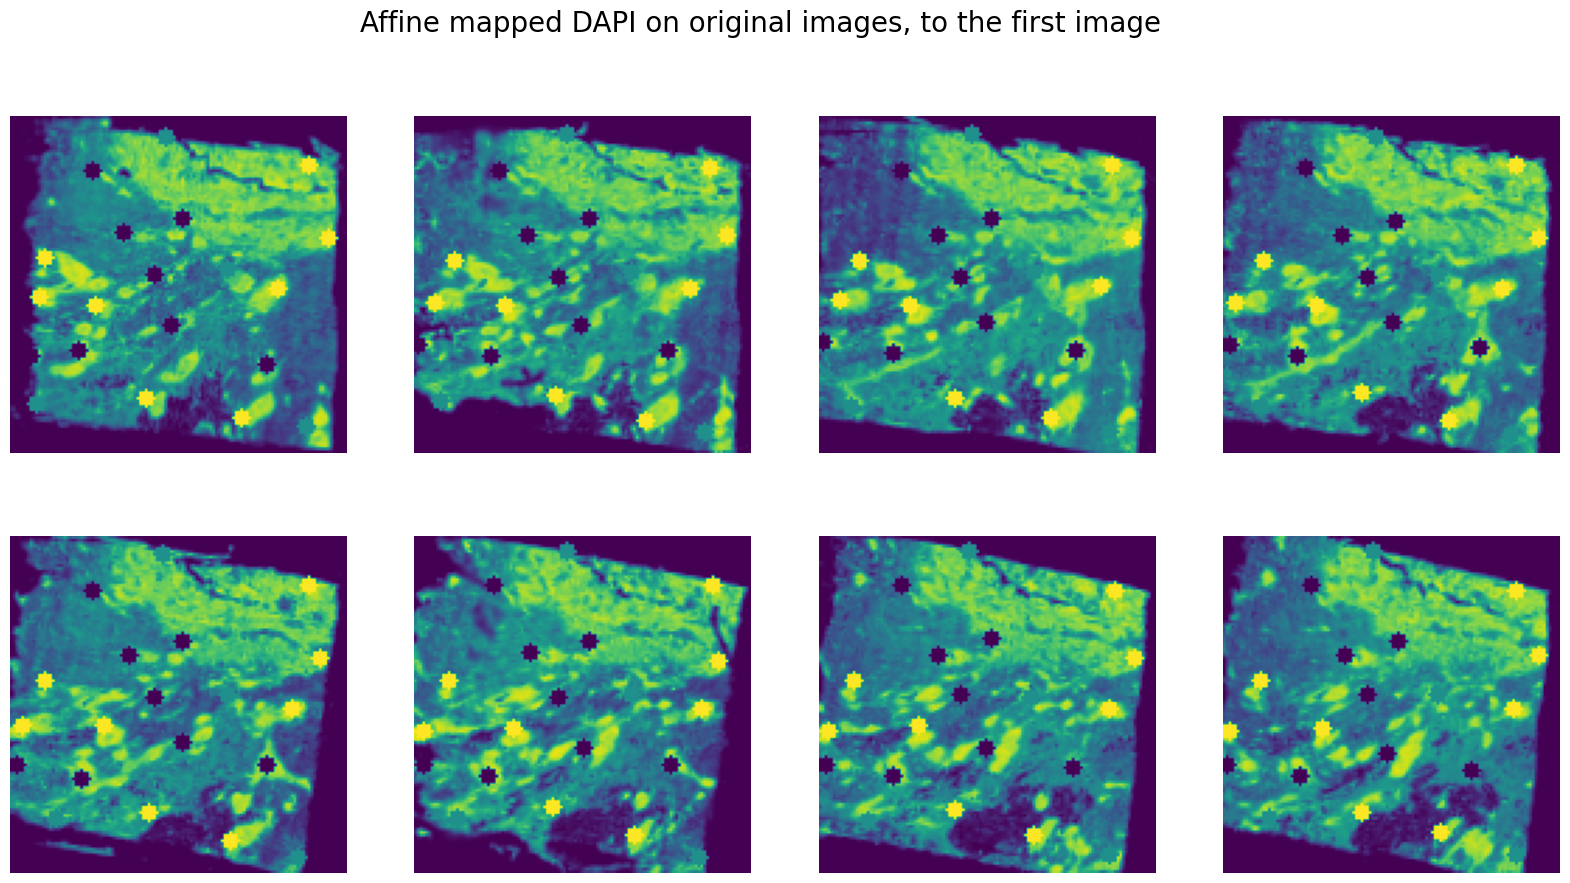

In [134]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(np_img_mapped[i])
    ax.axis('off')
    
fig.suptitle('Affine mapped DAPI on original images, to the first image', fontsize=20)

In [135]:
tps_mapped_imgs = tps_transform.warp_img(orig_imgs_t.cuda(), pts - 5, dst_pts - 5, reg=0, norm=True, size=120)
tps_mapped_pts = tps_transform.warp_pts(pts - 5, dst_pts - 5, pts - 5, reg=0)

np_img_mapped = toImg(tps_mapped_imgs.cuda()[:,:3], tps_mapped_pts, 120)

Text(0.5, 0.98, 'TPS mapped DAPI on original images to the first image')

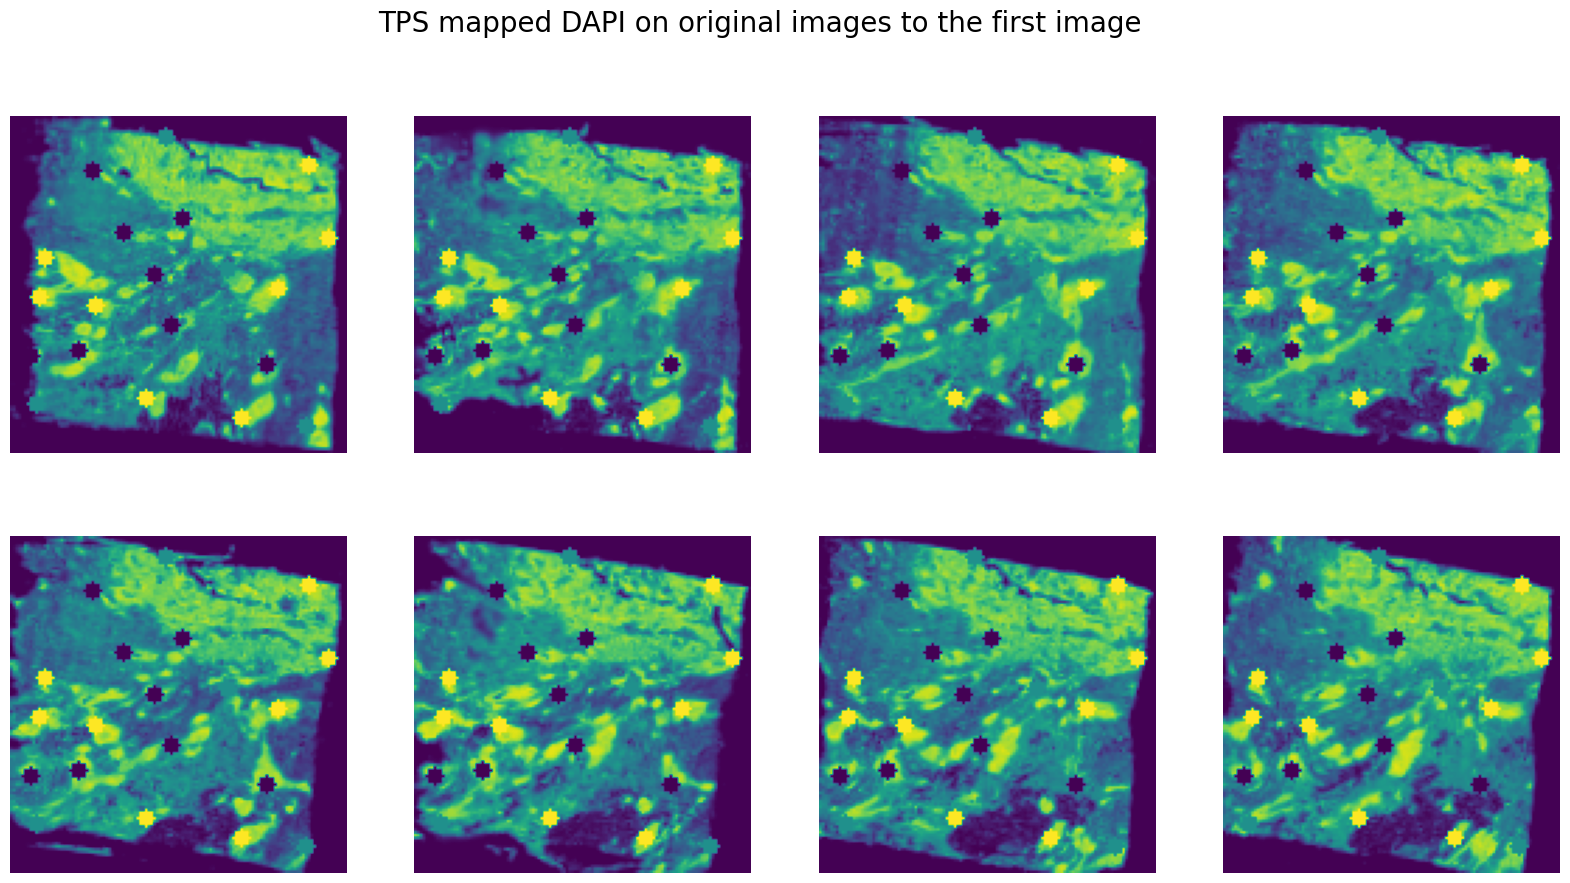

In [137]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(np_img_mapped[i])
    ax.axis('off')
    
fig.suptitle('TPS mapped DAPI on original images to the first image', fontsize=20)

In [138]:
def corr(batch1, batch2):
    batch_size = batch1.size(0)
    
    # Flatten the images
    batch1_flat = batch1.view(batch_size, -1)
    batch2_flat = batch2.view(batch_size, -1)

    # Normalize the data to have zero mean and unit variance
    batch1_flat = (batch1_flat - batch1_flat.mean(dim=1, keepdim=True)) / batch1_flat.std(dim=1, keepdim=True)
    batch2_flat = (batch2_flat - batch2_flat.mean(dim=1, keepdim=True)) / batch2_flat.std(dim=1, keepdim=True)

    # Compute the Pearson correlation
    pearson_correlation = (batch1_flat * batch2_flat).sum(dim=1) / (batch1_flat.size(1))
    return pearson_correlation

In [139]:
orig_corr = corr(orig_imgs_t[:-1], torch.cat([orig_imgs_t[i] for i in range(1, len(orig_imgs_t))])).mean()

In [140]:
affine_corr = corr(affine_mapped_imgs[:-1], torch.cat([affine_mapped_imgs[i] for i in range(1, len(affine_mapped_imgs))])).mean()

In [141]:
tps_corr = corr(tps_mapped_imgs[:-1], torch.cat([tps_mapped_imgs[i] for i in range(1, len(tps_mapped_imgs))])).mean()

In [142]:
print(f"Original correlation(No Transformaiton): {orig_corr}")
print(f"Affine correlation: {affine_corr}")
print(f"TPS correlation: {tps_corr}")

Original correlation(No Transformaiton): 0.5838062167167664
Affine correlation: 0.8547990322113037
TPS correlation: 0.8625847101211548
